## Accessing ECMWF Open Data – Real Time

The Planetary Computer includes data from the ECMWF Open Data (real time) program. See the [dataset](https://planetarycomputer.microsoft.com/dataset/ecmwf-forecast) page and [ECMWF Uesr Guide](https://confluence.ecmwf.int/display/UDOC/ECMWF+Open+Data+-+Real+Time) for more.

Each item in this collection includes metadata about the *stream* (or forecasting system) and *type* that produced that particular dataset. Filter on these values to select the item of interest. For example, we can select data from the `wave` stream, with the `fc` type that are forecast `0h` hours out.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace    
)
search = catalog.search(
    collections=["ecmwf-forecast"],
    query={
        "ecmwf:stream": {"eq": "wave"},
        "ecmwf:type": {"eq": "fc"},
        "ecmwf:step": {"eq": "0h"},
    },
)
items = search.get_all_items()
len(items)

359

We'll select the most recent item, using the item's datetime.

In [2]:
item = max(items, key=lambda item: item.datetime)
item

<Item id=ecmwf-2022-08-09T12-wave-fc-0h>

This STAC item has two assets. One asset is the actual GRIB2 file with the data. The second asset is the "index" file, which contains information about the messages within the GRIB2 file.

In [3]:
url = item.assets["data"].href
url.split("?")[0]

'https://ai4edataeuwest.blob.core.windows.net/ecmwf/20220809/12z/0p4-beta/wave/20220809120000-0h-wave-fc.grib2'

To open the file with xarray, we can download it locally and open it with `cfgrib`.

In [4]:
import urllib.request
import xarray as xr

filename, _ = urllib.request.urlretrieve(url)

ds = xr.open_dataset(filename, engine="cfgrib")
ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    swh         (latitude, longitude) float32 ...
    mwd         (latitude, longitude) float32 ...
    mwp         (latitude, longitude) float32 ...
    pp1d        (latitude, longitude) float32 ...
    mp2         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-08-10T15:53 GRIB to CDM+CF via cfgrib-0.9.1...

We can plot the various data variables, for example the significant height of combined wind waves and swell.

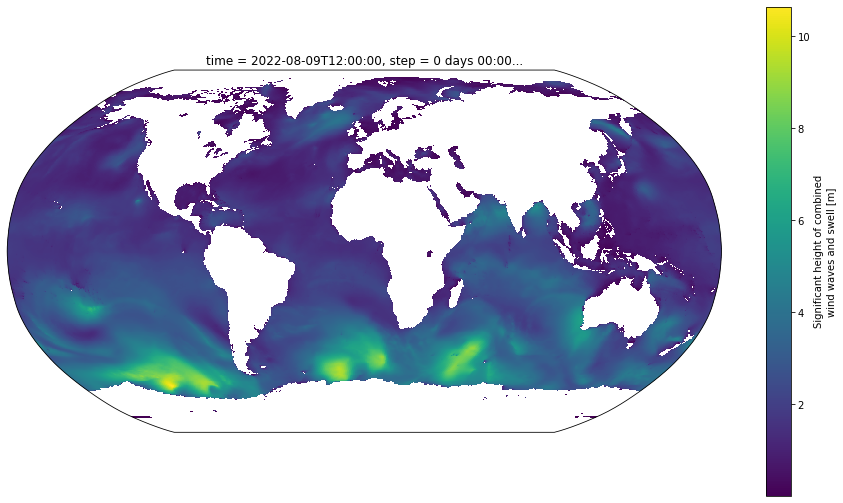

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

projection = projection = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

ds.swh.plot(ax=ax, transform=ccrs.PlateCarree());

Or the joint distribution between the wave period and height.

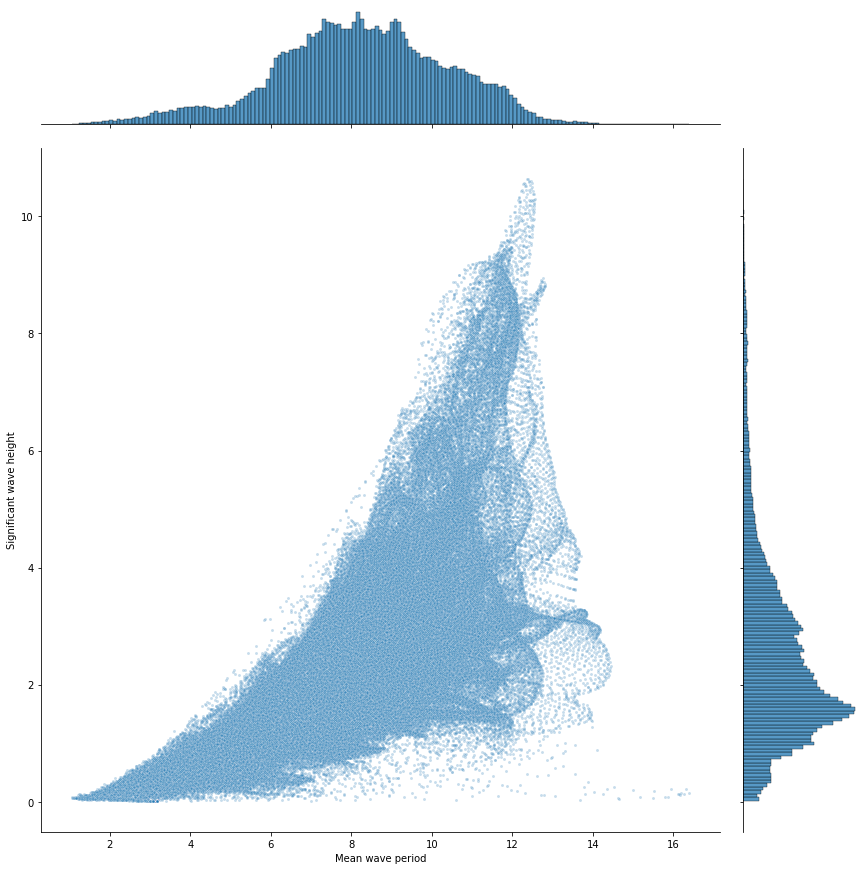

In [6]:
import seaborn as sns

grid = sns.jointplot(
    x=ds.mwp.data.ravel(), y=ds.swh.data.ravel(), alpha=0.25, marker=".", height=12
)
grid.ax_joint.set(xlabel="Mean wave period", ylabel="Significant wave height");

### GRIB2 files with multiple datasets 

Some GRIB2 files contain many messages that for separate xarray Datasets. For example, we can find the STAC item containing the atmospheric fields ensemble forecast (`stream=enfo`) from the ensemble forecast model (`type=ef`).

In [7]:
search = catalog.search(
    collections=["ecmwf-forecast"],
    query={
        "ecmwf:stream": {"eq": "enfo"},
        "ecmwf:type": {"eq": "ef"},
        "ecmwf:step": {"eq": "0h"},
    },
)
items = search.get_all_items()
print(len(items), "matched")
# select the most recent forecast
item = max(items, key=lambda item: item.datetime)

717 matched


In [8]:
url = item.assets["data"].href
filename, _ = urllib.request.urlretrieve(url)

If we provided just the `filename` to `xarray.open_datset`, we'd get an error from `cfgrib` saying it can't form a valid DataArray from the file. That's because the GRIB2 file contains multiple data variables that don't form a neat hypercube. Provide `filter_by_keys` to indicate which subset of the data to read in.

In [9]:
ds = xr.open_dataset(
    filename,
    engine="cfgrib",
    filter_by_keys={"dataType": "pf", "typeOfLevel": "surface"},
)
ds

<xarray.Dataset>
Dimensions:     (number: 50, latitude: 451, longitude: 900)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    tp          (number, latitude, longitude) float32 ...
    sp          (number, latitude, longitude) float32 ...
    skt         (number, latitude, longitude) float32 ...
    ro          (number, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-08-10T15:53 GRIB to CDM+CF via cfgrib-0.9.1...

Now we can plot the skin temperature, `skt`.

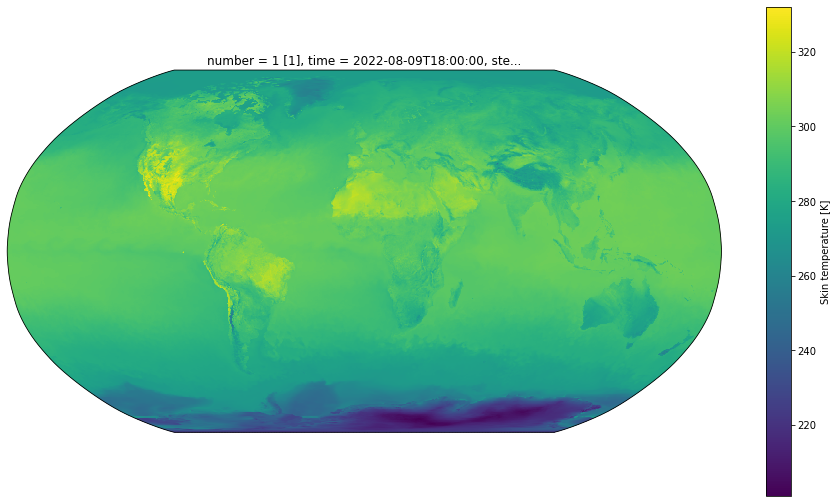

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

projection = projection = ccrs.Robinson()
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=projection))

ds.skt[0].plot(ax=ax, transform=ccrs.PlateCarree());

There are many more streams and forecast types available. See the [catalog](http://planetarycomputer.microsoft.com/dataset/ecmwf-forecast) for more.